In [0]:
from tqdm import tqdm
import pandas as pd
import pickle
import math
import random
import os
from pathlib import Path

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
SEED = 42
TRAIN_FRAC = 0.95
MAX_BLOCK_SIZE = 512
MODEL_NAME = "nopad_%d" % MAX_BLOCK_SIZE
GENRES = ['Action', 'Adult', 'Adventure', 'Animation',
    'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
    'Fantasy', 'Game-Show', 'History', 'Horror', 'Lifestyle', 'Music',
    'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
    'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']

# Remember to define the model dir in GDrive for persistence if using Colab
# This file as well as the Python scripts should be version controlled
GDRIVE_DIR = Path("drive/My Drive/Colab Notebooks/PlotGeneratorGPT2")
TRAIN_SCRIPT = GDRIVE_DIR/"run_lm_finetuning.py"
GENERATE_SCRIPT = GDRIVE_DIR/"run_generation.py"

# Model dir
MODEL_DIR = GDRIVE_DIR/MODEL_NAME
MODEL_DIR.mkdir(exist_ok=True)

# Cache
# Our custom tokenizer with special tokens will be stored here
CACHE_DIR = MODEL_DIR/'cache'
CACHE_DIR.mkdir(exist_ok=True)
TOKENIZER_DIR = CACHE_DIR/"tokenizer"
TOKENIZER_DIR.mkdir(exist_ok=True)
# Inputs will be stored here
TOKENS_FILE = CACHE_DIR/'tokens.pkl'
TRAIN_FILE = CACHE_DIR/'train.pkl'
TEST_FILE = CACHE_DIR/'test.pkl'

# Model checkpoints will be stored here
OUTPUT_DIR = MODEL_DIR/'output'
OUTPUT_DIR.mkdir(exist_ok=True)

# Logs for TensorBoard will be stored here
LOGS_DIR = MODEL_DIR/"logs"
LOGS_DIR.mkdir(exist_ok=True)

# Dumps will be stored here
DUMPS_DIR = MODEL_DIR/"dumps"
DUMPS_DIR.mkdir(exist_ok=True)

In [4]:
!nvidia-smi

Sun Nov 10 03:03:21 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Download data

In [5]:
!rm -rf data
!mkdir data
!wget https://github.com/davidsbatista/text-classification/blob/master/movies_genres.csv.bz2?raw=true -O data/movies_genres.csv.bz2

--2019-11-10 03:03:26--  https://github.com/davidsbatista/text-classification/blob/master/movies_genres.csv.bz2?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/davidsbatista/text-classification/raw/master/movies_genres.csv.bz2 [following]
--2019-11-10 03:03:27--  https://github.com/davidsbatista/text-classification/raw/master/movies_genres.csv.bz2
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davidsbatista/text-classification/master/movies_genres.csv.bz2 [following]
--2019-11-10 03:03:27--  https://raw.githubusercontent.com/davidsbatista/text-classification/master/movies_genres.csv.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubuserconte

In [0]:
df = pd.read_csv('data/movies_genres.csv.bz2', sep='\t')

## Configure tokenizer

In [7]:
!pip install transformers==2.1.1

In [8]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

100%|██████████| 456318/456318 [00:00<00:00, 504820.86B/s]


In [10]:
# Add special tokens
EOS_TOKEN = '<|endoftext|>'
PAD_TOKEN = '<|pad|>'

print(tokenizer.tokenize(EOS_TOKEN+PAD_TOKEN))
tokenizer.add_special_tokens({
    'eos_token': EOS_TOKEN,
    'pad_token': PAD_TOKEN
})
print(tokenizer.tokenize(EOS_TOKEN+PAD_TOKEN))

['<|endoftext|>', '<', '|', 'pad', '|', '>']
['<|endoftext|>', '<|pad|>']


In [11]:
# Add tokens
# We could just prepend genre labels as-is, it's all about convenience
EOG_TOKEN = '<|endofgenres|>'
EOT_TOKEN = '<|endoftitle|>'

special_tokens = [
    *list(map(lambda x: '<' + x.lower() + '>', GENRES)),
    EOG_TOKEN,
    EOT_TOKEN
]
print(tokenizer.tokenize(''.join(special_tokens)))
tokenizer.add_tokens(special_tokens)
print(tokenizer.tokenize(''.join(special_tokens)))

['<', 'action', '><', 'adult', '><', 'ad', 'venture', '><', 'anim', 'ation', '><', 'bi', 'ography', '><', 'com', 'edy', '><', 'crime', '><', 'document', 'ary', '><', 'd', 'rama', '><', 'family', '><', 'f', 'antasy', '><', 'game', '-', 'show', '><', 'history', '><', 'hor', 'ror', '><', 'l', 'ifestyle', '><', 'music', '><', 'mus', 'ical', '><', 'my', 'stery', '><', 'news', '><', 'reality', '-', 'tv', '><', 'rom', 'ance', '><', 'sci', '-', 'fi', '><', 'short', '><', 's', 'port', '><', 'talk', '-', 'show', '><', 'th', 'r', 'iller', '><', 'war', '><', 'western', '><', '|', 'end', 'of', 'gen', 'res', '|', '><', '|', 'end', 'oft', 'itle', '|', '>']
['<action>', '<adult>', '<adventure>', '<animation>', '<biography>', '<comedy>', '<crime>', '<documentary>', '<drama>', '<family>', '<fantasy>', '<game-show>', '<history>', '<horror>', '<lifestyle>', '<music>', '<musical>', '<mystery>', '<news>', '<reality-tv>', '<romance>', '<sci-fi>', '<short>', '<sport>', '<talk-show>', '<thriller>', '<war>', '<

In [12]:
# Save our custom tokenizer to disk
!rm -rf "$TOKENIZER_DIR"
!mkdir "$TOKENIZER_DIR"
tokenizer.save_pretrained(TOKENIZER_DIR)

('drive/My Drive/Colab Notebooks/PlotGeneratorGPT2/nopad_512/cache/tokenizer/vocab.json',
 'drive/My Drive/Colab Notebooks/PlotGeneratorGPT2/nopad_512/cache/tokenizer/merges.txt',
 'drive/My Drive/Colab Notebooks/PlotGeneratorGPT2/nopad_512/cache/tokenizer/special_tokens_map.json',
 'drive/My Drive/Colab Notebooks/PlotGeneratorGPT2/nopad_512/cache/tokenizer/added_tokens.json')

In [13]:
!cat "$TOKENIZER_DIR"/added_tokens.json

{"<|pad|>": 50257, "<action>": 50258, "<adult>": 50259, "<adventure>": 50260, "<animation>": 50261, "<biography>": 50262, "<comedy>": 50263, "<crime>": 50264, "<documentary>": 50265, "<drama>": 50266, "<family>": 50267, "<fantasy>": 50268, "<game-show>": 50269, "<history>": 50270, "<horror>": 50271, "<lifestyle>": 50272, "<music>": 50273, "<musical>": 50274, "<mystery>": 50275, "<news>": 50276, "<reality-tv>": 50277, "<romance>": 50278, "<sci-fi>": 50279, "<short>": 50280, "<sport>": 50281, "<talk-show>": 50282, "<thriller>": 50283, "<war>": 50284, "<western>": 50285, "<|endofgenres|>": 50286, "<|endoftitle|>": 50287}

## Prepare data

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117352 entries, 0 to 117351
Data columns (total 30 columns):
title          117352 non-null object
plot           117352 non-null object
Action         117352 non-null int64
Adult          117352 non-null int64
Adventure      117352 non-null int64
Animation      117352 non-null int64
Biography      117352 non-null int64
Comedy         117352 non-null int64
Crime          117352 non-null int64
Documentary    117352 non-null int64
Drama          117352 non-null int64
Family         117352 non-null int64
Fantasy        117352 non-null int64
Game-Show      117352 non-null int64
History        117352 non-null int64
Horror         117352 non-null int64
Lifestyle      117352 non-null int64
Music          117352 non-null int64
Musical        117352 non-null int64
Mystery        117352 non-null int64
News           117352 non-null int64
Reality-TV     117352 non-null int64
Romance        117352 non-null int64
Sci-Fi         117352 non-null int64

### Filter by language

In [15]:
!pip install langdetect

     |████████████████████████████████| 1.0MB 2.6MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993460 sha256=be8c0dad3188c7729b91d316b77acef6b6058e76fb94354d6374bd6c4918d068
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect


In [16]:
from langdetect import detect

# We want English plots only
plot_langs = []
for plot in tqdm(df['plot']):
    plot_langs.append(detect(plot))

100%|██████████| 117352/117352 [07:48<00:00, 250.73it/s]


In [17]:
df['plot_lang'] = plot_langs
df['plot_lang'].value_counts()

en    117196
nl       120
de        14
it         6
da         5
no         2
es         2
fr         2
pt         2
sv         1
hu         1
ca         1
Name: plot_lang, dtype: int64

In [0]:
df = df[df['plot_lang'].isin(['en'])]

### Prepare genres

In [19]:
df[GENRES].sum().sort_values()

Lifestyle          0
Adult             61
Short            578
Musical          595
Biography       1385
War             1407
Sport           1947
Game-Show       2045
Horror          2571
History         2662
Western         2761
Music           2837
News            3945
Talk-Show       5253
Fantasy         7103
Sci-Fi          8658
Thriller        8852
Adventure      10243
Animation      11369
Documentary    12020
Mystery        12026
Reality-TV     12336
Action         12376
Crime          15121
Family         15404
Romance        19174
Comedy         33870
Drama          45891
dtype: int64

In [20]:
# Build list of genres for each row
genre_df = df[GENRES].astype(bool)
plot_genres = []
for idx, row in tqdm(genre_df.iterrows()):
    plot_genres.append({genre for genre, isset in row.iteritems() if isset})

117196it [00:08, 14425.63it/s]


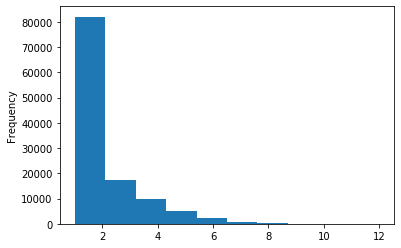

In [21]:
df['genres'] = plot_genres
df['genres'].apply(len).plot.hist()

In [22]:
df = df[['title', 'plot', 'genres']]

df.head()

,title,plot,genres
0,"""#7DaysLater"" (2013)",#7dayslater is an interactive comedy series f...,{Comedy}
1,"""#BlackLove"" (2015) {Crash the Party (#1.9)}","With just one week left in the workshops, the...",{Reality-TV}
2,"""#BlackLove"" (2015) {Making Lemonade Out of Le...",All of the women start making strides towards...,{Reality-TV}
3,"""#BlackLove"" (2015) {Miss Independent (#1.5)}",All five of these women are independent and s...,{Reality-TV}
4,"""#BlackLove"" (2015) {Sealing the Deal (#1.10)}",Despite having gone through a life changing p...,{Reality-TV}


### Tokenize

In [0]:
def tokenize_row(row):
    """Concatenate row information and tokenize for the use in GPT-2."""
    tokens = []
    # There is always a risk of overfitting when using a clear sentence structure
    # To avoid this, you can use simple randomization as for Magic: The Gathering cards
    # https://github.com/minimaxir/mtg-card-creator-api/blob/master/mtgencode/encode.py

    genre_tokens = list(map(lambda x: '<' + x.lower() + '>', row['genres']))
    random.shuffle(genre_tokens)
    tokens.extend(genre_tokens)
    tokens.append(EOG_TOKEN)
    tokens.extend(tokenizer.tokenize(row['title']))
    tokens.append(EOT_TOKEN)
    tokens.extend(tokenizer.tokenize(row['plot']))
    tokens.append(EOS_TOKEN)

    return tokens

In [24]:
tokens = []
for idx, row in tqdm(df.iterrows()):
    tokens.append(tokenize_row(row))

117196it [02:03, 951.63it/s]


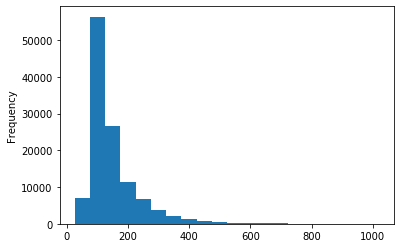

In [25]:
tokens_len_sr = pd.Series(tokens).apply(len)
tokens_len_sr = tokens_len_sr[tokens_len_sr <= 1024]
tokens_len_sr.plot.hist(bins=20)
# Derive the optimal block size from this plot

In [0]:
# Shuffle the order of plots
random.seed(SEED)
random.shuffle(tokens)

In [0]:
# Save tokens to disk
with open(TOKENS_FILE, "wb") as handle:
    pickle.dump(tokens, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Build inputs

In [0]:
with open(TOKENS_FILE, 'rb') as handle:
    tokens = pickle.load(handle)

In [0]:
def build_inputs_nopad(tokens):
    """Split tokens into equally-sized blocks and convert to inputs. No padding."""
    flat_tokens = [token for plot_tokens in tokens for token in plot_tokens]
    inputs = []
    # Truncate in block of MAX_BLOCK_SIZE
    # Note that we are losing the last truncated example here
    for i in tqdm(range(0, len(flat_tokens)-MAX_BLOCK_SIZE+1, MAX_BLOCK_SIZE)):
        block_tokens = flat_tokens[i:i+MAX_BLOCK_SIZE]
        block_tokens = tokenizer.convert_tokens_to_ids(block_tokens)
        # block_tokens = tokenizer.build_inputs_with_special_tokens(block_tokens)
        inputs.append(block_tokens)
    return inputs

In [30]:
inputs = build_inputs_nopad(tokens)

100%|██████████| 33755/33755 [00:12<00:00, 2675.93it/s]


In [31]:
pd.Series(inputs).apply(len).describe()

count    33755.0
mean       512.0
std          0.0
min        512.0
25%        512.0
50%        512.0
75%        512.0
max        512.0
dtype: float64

In [0]:
train_size = math.floor(TRAIN_FRAC * len(inputs))
train_inputs = inputs[:train_size]
test_inputs = inputs[train_size:]

In [0]:
# Save inputs to disk
with open(TRAIN_FILE, "wb") as handle:
    pickle.dump(train_inputs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(TEST_FILE, "wb") as handle:
    pickle.dump(test_inputs, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Train model

In [0]:
%load_ext tensorboard

In [35]:
%tensorboard --logdir "$LOGS_DIR"

In [36]:
# How to fit GPT-2 into GPU: https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255
# Good default parameters: https://github.com/minimaxir/gpt-2-simple/blob/master/gpt_2_simple/gpt_2.py
# run_lm_finetuning.py: https://github.com/huggingface/transformers/blob/master/examples/run_lm_finetuning.py

!python "$TRAIN_SCRIPT" \
    --output_dir="$OUTPUT_DIR" \
    --model_type=gpt2 \
    --model_name_or_path=gpt2 \
    --tokenizer_name_or_path="$TOKENIZER_DIR" \
    --do_train \
    --train_data_file="$TRAIN_FILE" \
    --log_dir="$LOGS_DIR" \
    --logging_steps=100 \
    --per_gpu_train_batch_size=4 \
    --gradient_accumulation_steps=1 \
    --learning_rate=1e-4 \
    --num_train_epochs=1 \
    --do_eval \
    --eval_data_file="$TEST_FILE" \
    --evaluate_during_training \
    --eval_steps=500 \
    --overwrite_output_dir \
    --overwrite_cache \
    --seed=$SEED

11/10/2019 03:15:00 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
11/10/2019 03:15:01 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.085d5f6a8e7812ea05ff0e6ed0645ab2e75d80387ad55c1ad9806ee70d272f80
11/10/2019 03:15:01 - INFO - transformers.configuration_utils -   Model config {
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_

## Generate dumps

In [0]:
def generate_dump(prompt, num_samples, temp, top_p):
    """Generate a dump of samples.
    Inspired by https://github.com/minimaxir/hacker-news-gpt-2"""
    
    samples = !python "$GENERATE_SCRIPT" \
        --model_type=gpt2 \
        --model_name_or_path="$OUTPUT_DIR" \
        --prompt="$prompt" \
        --temperature=$temp \
        --top_p=$top_p \
        --num_samples=$num_samples \
        --length=256 \
        --stop_token=EOS_TOKEN \
        --seed=$SEED
    return samples[-num_samples:]

In [0]:
def save_dumps(num_samples_per_genre=10, temps=[0.7, 1, 1.3], top_ps=[0, 0.9]):
    """Generate dumps of samples and save them to disk."""
    pbar = tqdm(total=len(GENRES)*len(temps)*len(top_ps), desc="Dumps")
    for temp in temps:
        for top_p in top_ps:
            samples = []
            for genre in GENRES:
                genre_token = '<' + genre.lower() + '>'
                prompt = genre_token + EOG_TOKEN
                dump = generate_dump(prompt, num_samples_per_genre, temp, top_p)
                for sample in dump:
                    samples.append(prompt + sample + "\n")
                pbar.update()
            fn = 'temp_%s_topp_%s.txt' % (str(temp).replace('.', '_'), 
                                          str(top_p).replace('.', '_'))
            with open(DUMPS_DIR/fn, 'w') as f:
                f.writelines(samples)
    pbar.close()

In [0]:
save_dumps()

Dumps:  58%|█████▊    | 97/168 [59:25<45:21, 38.34s/it]

11/10/2019 05:12:58 - INFO - transformers.tokenization_utils -   Model name 'drive/My Drive/Colab Notebooks/PlotGeneratorGPT2/nopad_512/output' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, distilgpt2). Assuming 'drive/My Drive/Colab Notebooks/PlotGeneratorGPT2/nopad_512/output' is a path or url to a directory containing tokenizer files.
11/10/2019 05:12:58 - INFO - transformers.tokenization_utils -   loading file drive/My Drive/Colab Notebooks/PlotGeneratorGPT2/nopad_512/output/vocab.json
11/10/2019 05:12:58 - INFO - transformers.tokenization_utils -   loading file drive/My Drive/Colab Notebooks/PlotGeneratorGPT2/nopad_512/output/merges.txt
11/10/2019 05:12:58 - INFO - transformers.tokenization_utils -   loading file drive/My Drive/Colab Notebooks/PlotGeneratorGPT2/nopad_512/output/added_tokens.json
11/10/2019 05:12:58 - INFO - transformers.tokenization_utils -   loading file drive/My Drive/Colab Notebooks/PlotGeneratorGPT2/nopad_512/output/special_tokens_map.j